In [142]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [143]:
df = pd.read_json('logins.json')
df.head()

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21


In [144]:
# As we visualize the head of the dataset, we are dealing with timeseries data.

In [145]:
# Aggregate these login counts based on 15 minute time intervals
df['num_logins']=1
df = df.set_index('login_time').resample('15min').sum()

In [146]:
df.head()

,num_logins
login_time,
1970-01-01 20:00:00,2
1970-01-01 20:15:00,6
1970-01-01 20:30:00,9
1970-01-01 20:45:00,7
1970-01-01 21:00:00,1


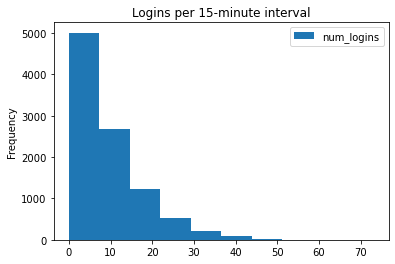

In [147]:
# Visualize and describe the resulting time series of login counts in ways that best characterize 
# the underlying patterns of the demand.
df.plot(kind='hist')
plt.title('Logins per 15-minute interval')
plt.show()

In [148]:
# checking if there are any missing data
df.isnull().sum()

num_logins    0
dtype: int64

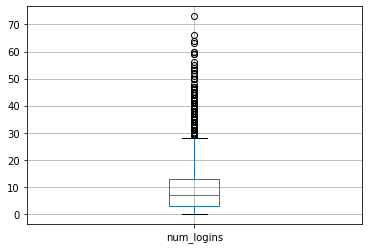

In [149]:
df.boxplot()
plt.show()

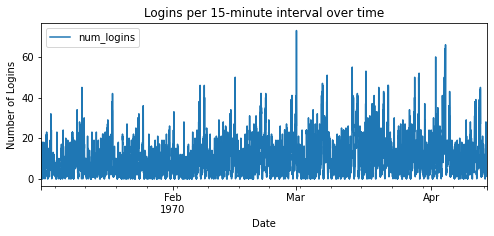

In [150]:
#plot the results
df.plot(xlabel='Date', ylabel='Number of Logins', figsize=(8,3), kind='line')
plt.title('Logins per 15-minute interval over time')
plt.show()

In [151]:
# While working with timeseries data, we need to ensure that the data has been stationarized, by removing seasonality and/or trend. 
# We can identify from the pattern that there is seasonality on the data. By using the seasonal decomposition, 
# we can remove seasonality, so the data is stationary.
from statsmodels.tsa.seasonal import seasonal_decompose

# In one month there are 4 * 24 * 7 * 4 = 2688 fifteen-minute increments
decomp = seasonal_decompose(df.num_logins, period=2688)

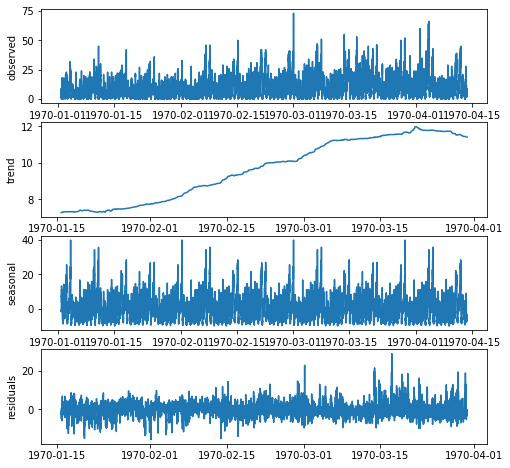

In [152]:
# Plot the original data, the trend, the seasonality, and the residuals 
fig, ax = plt.subplots(4, figsize=(8,8))

for i, attrib, name in zip([i for i in range(4)],
                        [decomp.observed, decomp.trend, decomp.seasonal, decomp.resid], 
                        ['observed', 'trend', 'seasonal', 'residuals']):
    ax[i].plot(attrib)
    ax[i].set_ylabel(name)
    
plt.show()

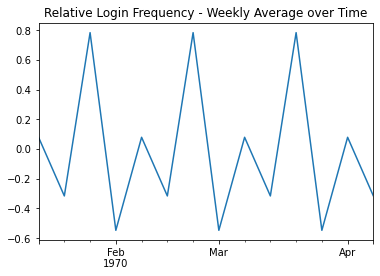

In [153]:
#resample weekly and plot, dropping first and last weeks due to edge effects
decomp.seasonal.resample('1W').mean()[1:-1].plot()
plt.title('Relative Login Frequency - Weekly Average over Time')
plt.xlabel(None)
plt.show()

Looks like an alternating trend in weekly demand with an increase in login frequency every fourth week, typically the last week of the month. We can observe trends within the week by resampling daily and isolating a single week for ease of inspection.

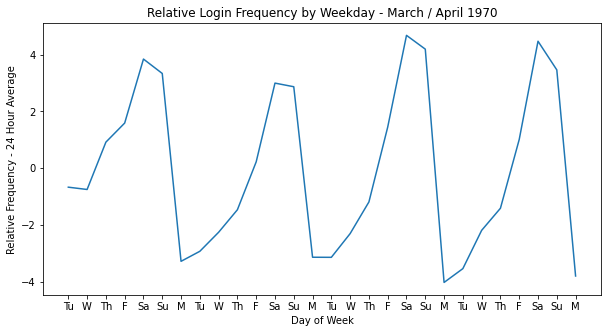

In [154]:
daily = decomp.seasonal.resample('1D').mean()
day_dict = {0:'M', 1:'Tu', 2:'W', 3:'Th', 4:'F', 5:'Sa', 6:'Su'}
#plot the last month of data
plt.figure(figsize=(10,5))
plt.plot(daily[-28:].index, daily[-28:].values)
plt.xticks(ticks=daily[-28:].index, 
           labels=daily[-28:].index.weekday.map(day_dict))
plt.xlabel('Day of Week')
plt.ylabel('Relative Frequency - 24 Hour Average')
plt.title('Relative Login Frequency by Weekday - March / April 1970')
plt.show()

There is a clear pattern with higher relative login frequency towards the end of the week and on the weekend, with a peak on Saturday and a drastic drop on Monday. We can look at daily patterns and how they change throughout the week as well.

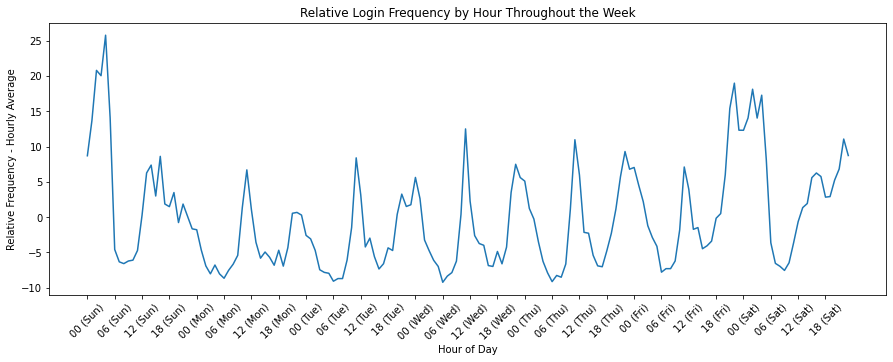

In [155]:
# resample hourly
hourly = decomp.seasonal.resample('1H').mean()

# changing i allows us to plot different weeks
i=1

# plot 
plt.figure(figsize=(15,5))
plt.plot(hourly[52 +7*24*i: 220 + 7*24*i].index, hourly[52 +7*24*i: 220 + 7*24*i].values)
plt.xticks(ticks=hourly[52 +7*24*i: 220 + 7*24*i:6].index, 
           labels=hourly[52 +7*24*i: 220 + 7*24*i:6].index.strftime('%H (%a)'),
           rotation=45)
plt.xlabel('Hour of Day')
plt.ylabel('Relative Frequency - Hourly Average')
plt.title('Relative Login Frequency by Hour Throughout the Week')
plt.show()

The login demands are highest during the lunch hour and in the evenings, increase throughout the week, increase on the last week of the month, and have had an increasing baseline from January to April.

In [156]:
df = pd.read_json('ultimate_data_challenge.json', convert_dates=['signup_date', 'last_trip_date'])
df.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


In [157]:
df.isnull().sum()

city                         0
trips_in_first_30_days       0
signup_date                  0
avg_rating_of_driver      8122
avg_surge                    0
last_trip_date               0
phone                      396
surge_pct                    0
ultimate_black_user          0
weekday_pct                  0
avg_dist                     0
avg_rating_by_driver       201
dtype: int64

We will fill null values with a signifier of -1 for numerical datatypes and "None" for strings. We will also convert booleans into integers.

In [158]:
df.avg_rating_of_driver = df.avg_rating_of_driver.fillna(value=-1)
df.avg_rating_by_driver = df.avg_rating_by_driver.fillna(value=-1)
df.phone = df.phone.fillna(value='None')
df.ultimate_black_user = df.ultimate_black_user.astype('int')

In [159]:
df.last_trip_date.describe(datetime_is_numeric=False)

/Users/elonazharri/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  """Entry point for launching an IPython kernel.


count                   50000
unique                    182
top       2014-06-29 00:00:00
freq                     2036
first     2014-01-01 00:00:00
last      2014-07-01 00:00:00
Name: last_trip_date, dtype: object

In [160]:
df['retained'] = (df.last_trip_date >= pd.to_datetime('2014-06-01')).astype('int')

In [161]:
pct = round(df.retained.value_counts()[1] / 50000 * 100)
print('{}% of drivers were retained.'.format(pct))

38% of drivers were retained.


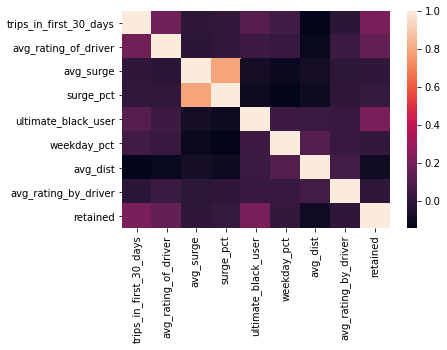

In [162]:
# checking the correlation
sns.heatmap(df.corr())
plt.show()

In [163]:
lost = df[df.retained == 0]
kept = df[df.retained == 1]

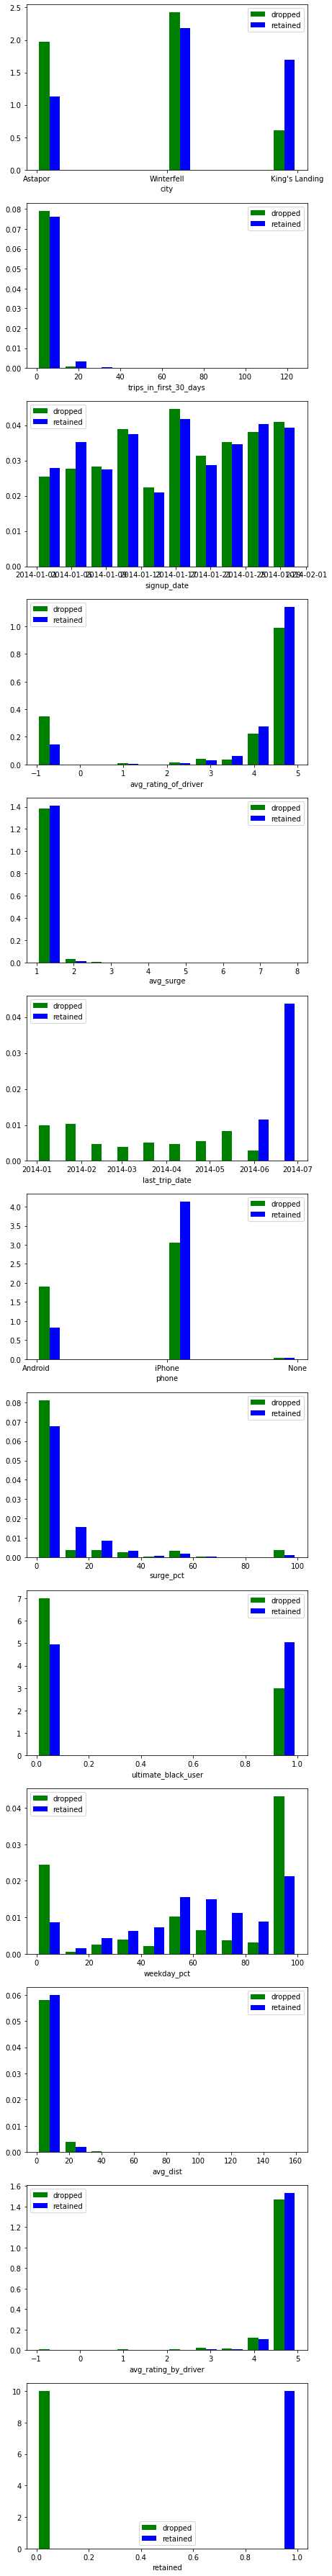

In [138]:
cols = df.columns
fig, axes = plt.subplots(len(cols), figsize=(7, 5*len(cols)))
for ax, col in zip(axes, cols): 
    ax.hist([lost[col], kept[col]], label=['dropped', 'retained'], density=True, color=['green', 'blue'])
    ax.legend()
    ax.set_xlabel(col)
plt.show()

In [164]:
df = pd.get_dummies(df).drop(columns=['signup_date', 'last_trip_date', 'city_Winterfell', 'phone_None'])
df

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,retained,city_Astapor,city_King's Landing,phone_Android,phone_iPhone
0,4,4.7,1.10,15.4,1,46.2,3.67,5.0,1,0,1,0,1
1,0,5.0,1.00,0.0,0,50.0,8.26,5.0,0,1,0,1,0
2,3,4.3,1.00,0.0,0,100.0,0.77,5.0,0,1,0,0,1
3,9,4.6,1.14,20.0,1,80.0,2.36,4.9,1,0,1,0,1
4,14,4.4,1.19,11.8,0,82.4,3.13,4.9,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,0,5.0,1.00,0.0,0,100.0,5.63,4.2,1,0,1,0,1
49996,1,-1.0,1.00,0.0,0,0.0,0.00,4.0,0,1,0,0,1
49997,0,5.0,1.00,0.0,1,100.0,3.86,5.0,0,0,0,1,0
49998,2,3.0,1.00,0.0,0,100.0,4.58,3.5,0,1,0,0,1


# Analyzing the model

In [28]:
!pip install xgboost

     |████████████████████████████████| 1.2 MB 4.8 MB/s eta 0:00:01


In [168]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   trips_in_first_30_days  50000 non-null  int64  
 1   avg_rating_of_driver    50000 non-null  float64
 2   avg_surge               50000 non-null  float64
 3   surge_pct               50000 non-null  float64
 4   ultimate_black_user     50000 non-null  int64  
 5   weekday_pct             50000 non-null  float64
 6   avg_dist                50000 non-null  float64
 7   avg_rating_by_driver    50000 non-null  float64
 8   retained                50000 non-null  int64  
 9   city_Astapor            50000 non-null  uint8  
 10  city_King's Landing     50000 non-null  uint8  
 11  phone_Android           50000 non-null  uint8  
 12  phone_iPhone            50000 non-null  uint8  
dtypes: float64(6), int64(3), uint8(4)
memory usage: 3.6 MB


In [169]:
from sklearn.model_selection import RandomizedSearchCV, cross_val_score, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import plot_confusion_matrix, precision_recall_fscore_support, plot_precision_recall_curve, balanced_accuracy_score
import xgboost as xgb
from sklearn import preprocessing

X = df.drop(columns='retained').values
y = df.retained.values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
#le = preprocessing.LabelEncoder()
#le.fit(y_train)

In [170]:
params = {
 'max_depth': [None, 10, 50, 100],
 'criterion': ['gini', 'entropy'],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 4],
 'min_samples_split': [2, 4, 10],
 'n_estimators': [100, 200, 500, 1000]
}

rf = RandomForestClassifier(random_state=1)
rf_cv = RandomizedSearchCV(rf, params, cv=3, scoring='balanced_accuracy', verbose=5, random_state=1)
rf_cv.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV 1/3] END criterion=entropy, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=4, n_estimators=100;, score=0.759 total time=   1.7s
[CV 2/3] END criterion=entropy, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=4, n_estimators=100;, score=0.756 total time=   1.7s
[CV 3/3] END criterion=entropy, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=4, n_estimators=100;, score=0.758 total time=   1.7s
[CV 1/3] END criterion=gini, max_depth=50, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=500;, score=0.749 total time=  11.5s
[CV 2/3] END criterion=gini, max_depth=50, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=500;, score=0.752 total time=  12.4s
[CV 3/3] END criterion=gini, max_depth=50, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=500;, score=0.757 total time=  11.2s
[CV 1/3] 

RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(random_state=1),
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': [None, 10, 50, 100],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 4],
                                        'min_samples_split': [2, 4, 10],
                                        'n_estimators': [100, 200, 500, 1000]},
                   random_state=1, scoring='balanced_accuracy', verbose=5)

In [171]:
#examine cv results
pd.DataFrame(rf_cv.cv_results_).sort_values('rank_test_score').T

,4,7,3,0,6,5,8,1,9,2
mean_fit_time,3.486861,14.091963,6.847984,1.543468,17.829983,15.499497,7.690043,10.550323,21.380092,10.947582
std_fit_time,0.019125,0.297734,0.029541,0.018666,0.329218,0.251745,0.130911,0.406037,0.292089,0.090513
mean_score_time,0.364124,1.370102,0.684003,0.146319,1.837124,1.394064,0.665095,1.179092,2.400791,1.237417
std_score_time,0.002145,0.031154,0.015145,0.008952,0.04538,0.103367,0.000598,0.112912,0.093211,0.014865
param_n_estimators,200,1000,500,100,1000,1000,500,500,1000,500
param_min_samples_split,4,10,2,4,4,4,4,10,4,2
param_min_samples_leaf,4,4,4,4,4,4,4,1,1,1
param_max_features,sqrt,sqrt,auto,auto,sqrt,sqrt,auto,auto,sqrt,sqrt
param_max_depth,100,10,10,10,50,10,10,50,50,50
param_criterion,gini,gini,gini,entropy,gini,entropy,entropy,gini,gini,gini


# XGBoost Classifier

In [172]:
params = {
    'max_depth': [None, 10, 50, 100],
    'learning_rate': [0.001, 0.01, 0.1, 0.2, 0.3],
    'min_child_weight': [0.5, 1.0, 3.0, 5.0],
    'gamma': [0, 0.25, 0.5, 1.0],
    'n_estimators': [10, 20, 50, 100],
    'colsample_bytree': [0.5, 0.7, 0.8, 0.9, 1],
    'objective': ['binary:logistic']
}

xgb_clf = xgb.XGBClassifier(random_state=1)
xgb_cv = RandomizedSearchCV(xgb_clf, params, cv=3, scoring='balanced_accuracy', verbose=5, random_state=1)

xgb_cv.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[21:02:20] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/elonazharri/opt/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 1/3] END colsample_bytree=1, gamma=0, learning_rate=0.001, max_depth=50, min_child_weight=1.0, n_estimators=20, objective=binary:logistic;, score=0.717 total time=   1.3s
[21:02:22] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/elonazharri/opt/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 2/3] END colsample_bytree=1, gamma=0, learning_rate=0.001, max_depth=50, min_child_weight=1.0, n_estimators=20, objective=binary:logistic;, score=0.715 total time=   1.3s
[21:02:23] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/elonazharri/opt/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 3/3] END colsample_bytree=1, gamma=0, learning_rate=0.001, max_depth=50, min_child_weight=1.0, n_estimators=20, objective=binary:logistic;, score=0.714 total time=   1.3s
[21:02:24] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/elonazharri/opt/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 1/3] END colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=50, min_child_weight=3.0, n_estimators=100, objective=binary:logistic;, score=0.751 total time=   3.7s
[21:02:28] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/elonazharri/opt/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 2/3] END colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=50, min_child_weight=3.0, n_estimators=100, objective=binary:logistic;, score=0.745 total time=   3.8s
[21:02:32] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/elonazharri/opt/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 3/3] END colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=50, min_child_weight=3.0, n_estimators=100, objective=binary:logistic;, score=0.757 total time=   3.9s
[21:02:36] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/3] END colsample_bytree=0.9, gamma=0, learning_rate=0.1, max_depth=None, min_child_weight=5.0, n_estimators=10, objective=binary:logistic;, score=0.754 total time=   0.2s
[21:02:36] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/elonazharri/opt/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/elonazharri/opt/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 2/3] END colsample_bytree=0.9, gamma=0, learning_rate=0.1, max_depth=None, min_child_weight=5.0, n_estimators=10, objective=binary:logistic;, score=0.750 total time=   0.1s
[21:02:36] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/3] END colsample_bytree=0.9, gamma=0, learning_rate=0.1, max_depth=None, min_child_weight=5.0, n_estimators=10, objective=binary:logistic;, score=0.755 total time=   0.1s
[21:02:36] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/elonazharri/opt/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/elonazharri/opt/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 1/3] END colsample_bytree=1, gamma=0, learning_rate=0.01, max_depth=None, min_child_weight=3.0, n_estimators=10, objective=binary:logistic;, score=0.739 total time=   0.1s
[21:02:36] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/3] END colsample_bytree=1, gamma=0, learning_rate=0.01, max_depth=None, min_child_weight=3.0, n_estimators=10, objective=binary:logistic;, score=0.744 total time=   0.2s
[21:02:36] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/elonazharri/opt/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/elonazharri/opt/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 3/3] END colsample_bytree=1, gamma=0, learning_rate=0.01, max_depth=None, min_child_weight=3.0, n_estimators=10, objective=binary:logistic;, score=0.743 total time=   0.2s
[21:02:37] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/elonazharri/opt/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 1/3] END colsample_bytree=0.5, gamma=0.5, learning_rate=0.3, max_depth=None, min_child_weight=3.0, n_estimators=20, objective=binary:logistic;, score=0.761 total time=   0.2s
[21:02:37] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/elonazharri/opt/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 2/3] END colsample_bytree=0.5, gamma=0.5, learning_rate=0.3, max_depth=None, min_child_weight=3.0, n_estimators=20, objective=binary:logistic;, score=0.758 total time=   0.2s
[21:02:37] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/elonazharri/opt/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 3/3] END colsample_bytree=0.5, gamma=0.5, learning_rate=0.3, max_depth=None, min_child_weight=3.0, n_estimators=20, objective=binary:logistic;, score=0.765 total time=   0.2s
[21:02:37] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/elonazharri/opt/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 1/3] END colsample_bytree=0.8, gamma=0, learning_rate=0.2, max_depth=None, min_child_weight=3.0, n_estimators=100, objective=binary:logistic;, score=0.764 total time=   1.0s
[21:02:38] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/elonazharri/opt/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 2/3] END colsample_bytree=0.8, gamma=0, learning_rate=0.2, max_depth=None, min_child_weight=3.0, n_estimators=100, objective=binary:logistic;, score=0.766 total time=   1.2s
[21:02:39] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/elonazharri/opt/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 3/3] END colsample_bytree=0.8, gamma=0, learning_rate=0.2, max_depth=None, min_child_weight=3.0, n_estimators=100, objective=binary:logistic;, score=0.768 total time=   1.0s
[21:02:40] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/elonazharri/opt/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 1/3] END colsample_bytree=0.8, gamma=0.25, learning_rate=0.001, max_depth=None, min_child_weight=5.0, n_estimators=100, objective=binary:logistic;, score=0.749 total time=   1.1s
[21:02:42] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/elonazharri/opt/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 2/3] END colsample_bytree=0.8, gamma=0.25, learning_rate=0.001, max_depth=None, min_child_weight=5.0, n_estimators=100, objective=binary:logistic;, score=0.745 total time=   1.0s
[21:02:43] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/elonazharri/opt/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 3/3] END colsample_bytree=0.8, gamma=0.25, learning_rate=0.001, max_depth=None, min_child_weight=5.0, n_estimators=100, objective=binary:logistic;, score=0.749 total time=   1.1s
[21:02:44] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/3] END colsample_bytree=0.9, gamma=1.0, learning_rate=0.3, max_depth=None, min_child_weight=0.5, n_estimators=10, objective=binary:logistic;, score=0.759 total time=   0.2s
[21:02:44] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/elonazharri/opt/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/elonazharri/opt/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 2/3] END colsample_bytree=0.9, gamma=1.0, learning_rate=0.3, max_depth=None, min_child_weight=0.5, n_estimators=10, objective=binary:logistic;, score=0.760 total time=   0.2s
[21:02:44] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/3] END colsample_bytree=0.9, gamma=1.0, learning_rate=0.3, max_depth=None, min_child_weight=0.5, n_estimators=10, objective=binary:logistic;, score=0.761 total time=   0.2s
[21:02:44] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/elonazharri/opt/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/elonazharri/opt/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 1/3] END colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=10, min_child_weight=0.5, n_estimators=10, objective=binary:logistic;, score=0.746 total time=   0.3s
[21:02:44] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/elonazharri/opt/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 2/3] END colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=10, min_child_weight=0.5, n_estimators=10, objective=binary:logistic;, score=0.746 total time=   0.3s
[21:02:45] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/elonazharri/opt/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 3/3] END colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=10, min_child_weight=0.5, n_estimators=10, objective=binary:logistic;, score=0.749 total time=   0.3s
[21:02:45] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/elonazharri/opt/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 1/3] END colsample_bytree=0.9, gamma=0.25, learning_rate=0.01, max_depth=None, min_child_weight=0.5, n_estimators=20, objective=binary:logistic;, score=0.749 total time=   0.3s
[21:02:45] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/elonazharri/opt/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 2/3] END colsample_bytree=0.9, gamma=0.25, learning_rate=0.01, max_depth=None, min_child_weight=0.5, n_estimators=20, objective=binary:logistic;, score=0.743 total time=   0.3s
[21:02:46] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/elonazharri/opt/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 3/3] END colsample_bytree=0.9, gamma=0.25, learning_rate=0.01, max_depth=None, min_child_weight=0.5, n_estimators=20, objective=binary:logistic;, score=0.747 total time=   0.3s
[21:02:46] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/elonazharri/opt/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


RandomizedSearchCV(cv=3,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, gamma=None,
                                           gpu_id=None, importance_type='gain',
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None, max_depth=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           n_estimators=100,...
                                           subsample=None, tree_method=None,
                                           validate_parameters=None,
                                   

In [173]:
#examine cv results
pd.DataFrame(xgb_cv.cv_results_).sort_values('rank_test_score').T

,5,4,7,2,1,6,8,9,3,0
mean_fit_time,1.046562,0.204773,0.140901,0.122861,3.738671,1.022073,0.26524,0.253262,0.12761,1.264964
std_fit_time,0.069779,0.014397,0.007404,0.007686,0.064191,0.008522,0.002737,0.020473,0.005711,0.017586
mean_score_time,0.031966,0.025252,0.024225,0.021612,0.047796,0.035959,0.024755,0.025107,0.02248,0.026669
std_score_time,0.001186,0.001574,0.000595,0.000539,0.002714,0.001191,0.000723,0.00006,0.000418,0.003421
param_objective,binary:logistic,binary:logistic,binary:logistic,binary:logistic,binary:logistic,binary:logistic,binary:logistic,binary:logistic,binary:logistic,binary:logistic
param_n_estimators,100,20,10,10,100,100,10,20,10,20
param_min_child_weight,3.0,3.0,0.5,5.0,3.0,5.0,0.5,0.5,3.0,1.0
param_max_depth,None,None,None,None,50,None,10,None,None,50
param_learning_rate,0.2,0.3,0.3,0.1,0.2,0.001,0.1,0.01,0.01,0.001
param_gamma,0,0.5,1.0,0,0,0.25,0,0.25,0,0


# K-Means Classifier

In [175]:
#first scale data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)
X_tr_scaled = scaler.transform(X_train)
X_te_scaled = scaler.transform(X_test)

In [176]:
from sklearn.neighbors import KNeighborsClassifier
#try several values for n_neighbors
scores_dict = {}
for i in list(range(2,9,2)) + list(range(10,100,10)):
    knn = KNeighborsClassifier(n_neighbors=i)
    scores = cross_val_score(knn, X_tr_scaled, y_train, scoring='balanced_accuracy', cv=3)
    temp = {}
    temp['mean'] = np.mean(scores)
    temp['std'] = np.std(scores)
    scores_dict[i] = temp

<AxesSubplot:xlabel='index', ylabel='mean'>

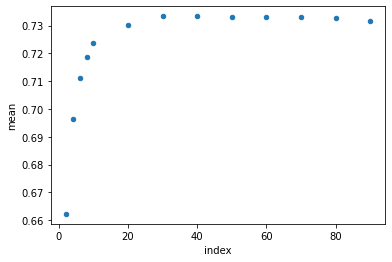

In [177]:
pd.DataFrame(scores_dict).T.reset_index().plot(x='index', y='mean', kind='scatter')

# Logistic Regression

In [178]:
from sklearn.linear_model import LogisticRegression
X_trs, X_vals, y_tr, y_val = train_test_split(X_tr_scaled, y_train, test_size=0.2)
lr = LogisticRegression()
lr.fit(X_trs, y_tr)
y_tr_preds = lr.predict(X_trs)
y_val_preds = lr.predict(X_vals)
balanced_accuracy_score(y_tr, y_tr_preds)

0.6777434392701918

In [179]:
balanced_accuracy_score(y_val, y_val_preds)

0.6799676329847999

# Model Selection and Evaluation

The XGBoost model shows the best overall performance with a cross-validated balanced accuracy of 77%, so we choose XGBoost model.

In [180]:
xgb_clf = xgb_cv.best_estimator_

xgb_clf.fit(X_train, y_train)

y_preds = xgb_clf.predict(X_test)

balanced_accuracy_score(y_test, y_preds)

/Users/elonazharri/opt/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:09:25] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


0.7624233048549749

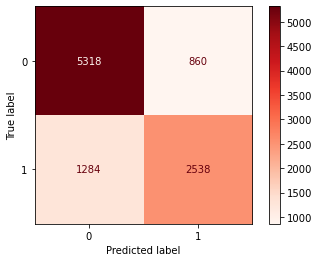

In [182]:
plot_confusion_matrix(xgb_clf, X_test, y_test, cmap='Reds')

In [183]:
accuracy = (5362 + 2569) / (5362 + 2569 + 1253 + 816)
print('The overall test accuracy is {}'.format(accuracy))

The overall test accuracy is 0.7931


In [ ]:
pd.DataFrame(precision_recall_fscore_support(y_test, y_preds), 
             index=['Precision', 'Recall', 'Fscore', 'Support'])

In [ ]:
from sklearn.metrics import plot_roc_curve
plot_roc_curve(xgb_clf, X_test, y_test)